In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, model_selection
from xgboost import XGBRegressor, XGBClassifier
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("bitcoin_daily_prices.csv", parse_dates=["date"])
df.head()

,open_time,open,high,low,close,volume,close_time,quote,no_trades,base_buy,quote_buy,ignore,date
0,1577836800000,7195.24,7255.0,7175.15,7200.85,16792.388165,1577923199999,1.212145e+08,194010,8946.955535,6.459779e+07,0,2020-01-01 05:30:00
1,1577923200000,7200.77,7212.5,6924.74,6965.71,31951.483932,1578009599999,2.259823e+08,302667,15141.611340,1.070608e+08,0,2020-01-02 05:30:00
2,1578009600000,6965.49,7405.0,6871.04,7344.96,68428.500451,1578095999999,4.950986e+08,519854,35595.496273,2.577131e+08,0,2020-01-03 05:30:00
3,1578096000000,7345.00,7404.0,7272.21,7354.11,29987.974977,1578182399999,2.198742e+08,279370,16369.382248,1.200351e+08,0,2020-01-04 05:30:00
4,1578182400000,7354.19,7495.0,7318.00,7358.75,38331.085604,1578268799999,2.848487e+08,329209,19455.369564,1.446001e+08,0,2020-01-05 05:30:00


In [3]:
# Feature Engineering
df = pd.DataFrame(df["close"].values)

# Let us take the last 10 days values as inputs
n_in = 20
cols = list()
for i in range(n_in, 0, -1):
    cols.append(df.shift(i))

# Let us take the next days value as the target
n_out = 1
cols.append(df.shift(-n_out))

# Concat all to create the data
full_df = pd.concat(cols, axis=1)
full_df

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6965.71
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7200.85,7344.96
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7200.85,6965.71,7354.11
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7200.85,6965.71,7344.96,7358.75
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7200.85,6965.71,7344.96,7354.11,7758.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,58413.44,60575.89,62253.71,61859.19,61299.80,60911.11,63219.99,62896.48,61395.01,60937.12,...,63273.59,67525.83,66947.66,64882.43,64774.26,64122.23,64380.00,65519.10,63606.74,60344.87
686,60575.89,62253.71,61859.19,61299.80,60911.11,63219.99,62896.48,61395.01,60937.12,61470.61,...,67525.83,66947.66,64882.43,64774.26,64122.23,64380.00,65519.10,63606.74,60058.87,56891.62
687,62253.71,61859.19,61299.80,60911.11,63219.99,62896.48,61395.01,60937.12,61470.61,63273.59,...,66947.66,64882.43,64774.26,64122.23,64380.00,65519.10,63606.74,60058.87,60344.87,58052.24
688,61859.19,61299.80,60911.11,63219.99,62896.48,61395.01,60937.12,61470.61,63273.59,67525.83,...,64882.43,64774.26,64122.23,64380.00,65519.10,63606.74,60058.87,60344.87,56891.62,58503.09


In [4]:
# Drop the Nan values
full_df = full_df.dropna().reset_index(drop=True)

# Create column names
full_df.columns = [f't{i}' for i in range(n_in, 0, -1)] + ['target']
full_df

,t20,t19,t18,t17,t16,t15,t14,t13,t12,t11,...,t9,t8,t7,t6,t5,t4,t3,t2,t1,target
0,7200.85,6965.71,7344.96,7354.11,7358.75,7758.00,8145.28,8055.98,7817.76,8197.02,...,8184.98,8110.34,8810.01,8821.41,8720.01,8913.28,8915.96,8701.70,8642.35,8682.36
1,6965.71,7344.96,7354.11,7358.75,7758.00,8145.28,8055.98,7817.76,8197.02,8020.01,...,8110.34,8810.01,8821.41,8720.01,8913.28,8915.96,8701.70,8642.35,8736.03,8404.52
2,7344.96,7354.11,7358.75,7758.00,8145.28,8055.98,7817.76,8197.02,8020.01,8184.98,...,8810.01,8821.41,8720.01,8913.28,8915.96,8701.70,8642.35,8736.03,8682.36,8439.00
3,7354.11,7358.75,7758.00,8145.28,8055.98,7817.76,8197.02,8020.01,8184.98,8110.34,...,8821.41,8720.01,8913.28,8915.96,8701.70,8642.35,8736.03,8682.36,8404.52,8340.58
4,7358.75,7758.00,8145.28,8055.98,7817.76,8197.02,8020.01,8184.98,8110.34,8810.01,...,8720.01,8913.28,8915.96,8701.70,8642.35,8736.03,8682.36,8404.52,8439.00,8615.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,60328.81,58413.44,60575.89,62253.71,61859.19,61299.80,60911.11,63219.99,62896.48,61395.01,...,61470.61,63273.59,67525.83,66947.66,64882.43,64774.26,64122.23,64380.00,65519.10,60058.87
665,58413.44,60575.89,62253.71,61859.19,61299.80,60911.11,63219.99,62896.48,61395.01,60937.12,...,63273.59,67525.83,66947.66,64882.43,64774.26,64122.23,64380.00,65519.10,63606.74,60344.87
666,60575.89,62253.71,61859.19,61299.80,60911.11,63219.99,62896.48,61395.01,60937.12,61470.61,...,67525.83,66947.66,64882.43,64774.26,64122.23,64380.00,65519.10,63606.74,60058.87,56891.62
667,62253.71,61859.19,61299.80,60911.11,63219.99,62896.48,61395.01,60937.12,61470.61,63273.59,...,66947.66,64882.43,64774.26,64122.23,64380.00,65519.10,63606.74,60058.87,60344.87,58052.24


In [5]:
# Input and Target features
input_col_names = [f't{i}' for i in range(n_in, 0, -1)]
target_col_name = 'target'

In [6]:
# Normalize the features
full_df['target'] = full_df['target'] - full_df['t1']
for col in input_col_names:
    full_df[col] = full_df[col] - full_df['t1']
full_df

,t20,t19,t18,t17,t16,t15,t14,t13,t12,t11,...,t9,t8,t7,t6,t5,t4,t3,t2,t1,target
0,-1441.50,-1676.64,-1297.39,-1288.24,-1283.60,-884.35,-497.07,-586.37,-824.59,-445.33,...,-457.37,-532.01,167.66,179.06,77.66,270.93,273.61,59.35,0.0,40.01
1,-1770.32,-1391.07,-1381.92,-1377.28,-978.03,-590.75,-680.05,-918.27,-539.01,-716.02,...,-625.69,73.98,85.38,-16.02,177.25,179.93,-34.33,-93.68,0.0,-331.51
2,-1337.40,-1328.25,-1323.61,-924.36,-537.08,-626.38,-864.60,-485.34,-662.35,-497.38,...,127.65,139.05,37.65,230.92,233.60,19.34,-40.01,53.67,0.0,-243.36
3,-1050.41,-1045.77,-646.52,-259.24,-348.54,-586.76,-207.50,-384.51,-219.54,-294.18,...,416.89,315.49,508.76,511.44,297.18,237.83,331.51,277.84,0.0,-63.94
4,-1080.25,-681.00,-293.72,-383.02,-621.24,-241.98,-418.99,-254.02,-328.66,371.01,...,281.01,474.28,476.96,262.70,203.35,297.03,243.36,-34.48,0.0,176.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,-5190.29,-7105.66,-4943.21,-3265.39,-3659.91,-4219.30,-4607.99,-2299.11,-2622.62,-4124.09,...,-4048.49,-2245.51,2006.73,1428.56,-636.67,-744.84,-1396.87,-1139.10,0.0,-5460.23
665,-5193.30,-3030.85,-1353.03,-1747.55,-2306.94,-2695.63,-386.75,-710.26,-2211.73,-2669.62,...,-333.15,3919.09,3340.92,1275.69,1167.52,515.49,773.26,1912.36,0.0,-3261.87
666,517.02,2194.84,1800.32,1240.93,852.24,3161.12,2837.61,1336.14,878.25,1411.74,...,7466.96,6888.79,4823.56,4715.39,4063.36,4321.13,5460.23,3547.87,0.0,-3167.25
667,1908.84,1514.32,954.93,566.24,2875.12,2551.61,1050.14,592.25,1125.74,2928.72,...,6602.79,4537.56,4429.39,3777.36,4035.13,5174.23,3261.87,-286.00,0.0,-2292.63


In [7]:
# Split the dataset into train and validation dataset
tfold = model_selection.TimeSeriesSplit(n_splits=2, test_size=100)
for dev_index, val_index in tfold.split(full_df):
    train_df = full_df.iloc[dev_index, :]
    val_df = full_df.iloc[val_index, :]
train_df

,t20,t19,t18,t17,t16,t15,t14,t13,t12,t11,...,t9,t8,t7,t6,t5,t4,t3,t2,t1,target
0,-1441.50,-1676.64,-1297.39,-1288.24,-1283.60,-884.35,-497.07,-586.37,-824.59,-445.33,...,-457.37,-532.01,167.66,179.06,77.66,270.93,273.61,59.35,0.0,40.01
1,-1770.32,-1391.07,-1381.92,-1377.28,-978.03,-590.75,-680.05,-918.27,-539.01,-716.02,...,-625.69,73.98,85.38,-16.02,177.25,179.93,-34.33,-93.68,0.0,-331.51
2,-1337.40,-1328.25,-1323.61,-924.36,-537.08,-626.38,-864.60,-485.34,-662.35,-497.38,...,127.65,139.05,37.65,230.92,233.60,19.34,-40.01,53.67,0.0,-243.36
3,-1050.41,-1045.77,-646.52,-259.24,-348.54,-586.76,-207.50,-384.51,-219.54,-294.18,...,416.89,315.49,508.76,511.44,297.18,237.83,331.51,277.84,0.0,-63.94
4,-1080.25,-681.00,-293.72,-383.02,-621.24,-241.98,-418.99,-254.02,-328.66,371.01,...,281.01,474.28,476.96,262.70,203.35,297.03,243.36,-34.48,0.0,176.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,-11058.31,-11997.22,-13046.52,-10692.36,-10549.04,-9202.78,-8578.73,-7455.85,-5599.27,-3379.00,...,-2820.39,-630.50,-1375.04,-2991.43,-3689.05,-4629.82,-3113.69,-1974.41,0.0,957.50
565,-13732.89,-14782.19,-12428.03,-12284.71,-10938.45,-10314.40,-9191.52,-7334.94,-5114.67,-4552.98,...,-2366.17,-3110.71,-4727.10,-5424.72,-6365.49,-4849.36,-3710.08,-1735.67,0.0,1680.86
566,-14004.02,-11649.86,-11506.54,-10160.28,-9536.23,-8413.35,-6556.77,-4336.50,-3774.81,-3777.89,...,-2332.54,-3948.93,-4646.55,-5587.32,-4071.19,-2931.91,-957.50,778.17,0.0,1790.62
567,-14108.89,-13965.57,-12619.31,-11995.26,-10872.38,-9015.80,-6795.53,-6233.84,-6236.92,-4047.03,...,-6407.96,-7105.58,-8046.35,-6530.22,-5390.94,-3416.53,-1680.86,-2459.03,0.0,-742.40


In [8]:
val_df

,t20,t19,t18,t17,t16,t15,t14,t13,t12,t11,...,t9,t8,t7,t6,t5,t4,t3,t2,t1,target
569,-11876.91,-11252.86,-10129.98,-8273.40,-6053.13,-5491.44,-5494.52,-3304.63,-4049.17,-5665.56,...,-7303.95,-5787.82,-4648.54,-2674.13,-938.46,-1716.63,742.40,73.99,0.0,2289.00
570,-10140.86,-9017.98,-7161.40,-4941.13,-4379.44,-4382.52,-2192.63,-2937.17,-4553.56,-5251.18,...,-4675.82,-3536.54,-1562.13,173.54,-604.63,1854.40,1185.99,1112.00,0.0,2669.51
571,-12418.98,-10562.40,-8342.13,-7780.44,-7783.52,-5593.63,-6338.17,-7954.56,-8652.18,-9592.95,...,-6937.54,-4963.13,-3227.46,-4005.63,-1546.60,-2215.01,-2289.00,-3401.00,0.0,-826.18
572,-9830.91,-7610.64,-7048.95,-7052.03,-4862.14,-5606.68,-7223.07,-7920.69,-8861.46,-7345.33,...,-4231.64,-2495.97,-3274.14,-815.11,-1483.52,-1557.51,-2669.51,731.49,0.0,-1167.22
573,-7515.95,-6954.26,-6957.34,-4767.45,-5511.99,-7128.38,-7826.00,-8766.77,-7250.64,-6111.36,...,-2401.28,-3179.45,-720.42,-1388.83,-1462.82,-2574.82,826.18,94.69,0.0,-2277.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,-5190.29,-7105.66,-4943.21,-3265.39,-3659.91,-4219.30,-4607.99,-2299.11,-2622.62,-4124.09,...,-4048.49,-2245.51,2006.73,1428.56,-636.67,-744.84,-1396.87,-1139.10,0.0,-5460.23
665,-5193.30,-3030.85,-1353.03,-1747.55,-2306.94,-2695.63,-386.75,-710.26,-2211.73,-2669.62,...,-333.15,3919.09,3340.92,1275.69,1167.52,515.49,773.26,1912.36,0.0,-3261.87
666,517.02,2194.84,1800.32,1240.93,852.24,3161.12,2837.61,1336.14,878.25,1411.74,...,7466.96,6888.79,4823.56,4715.39,4063.36,4321.13,5460.23,3547.87,0.0,-3167.25
667,1908.84,1514.32,954.93,566.24,2875.12,2551.61,1050.14,592.25,1125.74,2928.72,...,6602.79,4537.56,4429.39,3777.36,4035.13,5174.23,3261.87,-286.00,0.0,-2292.63


In [9]:
train_X = train_df[input_col_names]
train_y = train_df[target_col_name]

val_X = val_df[input_col_names]
val_y = val_df[target_col_name]

## Model Building

In [10]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
model.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
preds = model.predict(val_X)
rmse = np.sqrt(metrics.mean_squared_error(val_y, preds))
print("RMSE: %f" % (rmse))

RMSE: 2950.025956


In [12]:
pred_df = pd.DataFrame({"Actuals":val_y, "Predictions":preds})
pred_df

,Actuals,Predictions
569,2289.00,1243.048706
570,2669.51,-1559.843262
571,-826.18,3665.163818
572,-1167.22,3000.340820
573,-2277.87,850.825562
...,...,...
664,-5460.23,-1062.473145
665,-3261.87,-545.781311
666,-3167.25,1289.361450
667,-2292.63,-1761.152222


## Classification Model

In [13]:
full_df["binary_target"] = (full_df["target"] > full_df["t1"]).astype(int)
full_df

,t20,t19,t18,t17,t16,t15,t14,t13,t12,t11,...,t8,t7,t6,t5,t4,t3,t2,t1,target,binary_target
0,-1441.50,-1676.64,-1297.39,-1288.24,-1283.60,-884.35,-497.07,-586.37,-824.59,-445.33,...,-532.01,167.66,179.06,77.66,270.93,273.61,59.35,0.0,40.01,1
1,-1770.32,-1391.07,-1381.92,-1377.28,-978.03,-590.75,-680.05,-918.27,-539.01,-716.02,...,73.98,85.38,-16.02,177.25,179.93,-34.33,-93.68,0.0,-331.51,0
2,-1337.40,-1328.25,-1323.61,-924.36,-537.08,-626.38,-864.60,-485.34,-662.35,-497.38,...,139.05,37.65,230.92,233.60,19.34,-40.01,53.67,0.0,-243.36,0
3,-1050.41,-1045.77,-646.52,-259.24,-348.54,-586.76,-207.50,-384.51,-219.54,-294.18,...,315.49,508.76,511.44,297.18,237.83,331.51,277.84,0.0,-63.94,0
4,-1080.25,-681.00,-293.72,-383.02,-621.24,-241.98,-418.99,-254.02,-328.66,371.01,...,474.28,476.96,262.70,203.35,297.03,243.36,-34.48,0.0,176.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,-5190.29,-7105.66,-4943.21,-3265.39,-3659.91,-4219.30,-4607.99,-2299.11,-2622.62,-4124.09,...,-2245.51,2006.73,1428.56,-636.67,-744.84,-1396.87,-1139.10,0.0,-5460.23,0
665,-5193.30,-3030.85,-1353.03,-1747.55,-2306.94,-2695.63,-386.75,-710.26,-2211.73,-2669.62,...,3919.09,3340.92,1275.69,1167.52,515.49,773.26,1912.36,0.0,-3261.87,0
666,517.02,2194.84,1800.32,1240.93,852.24,3161.12,2837.61,1336.14,878.25,1411.74,...,6888.79,4823.56,4715.39,4063.36,4321.13,5460.23,3547.87,0.0,-3167.25,0
667,1908.84,1514.32,954.93,566.24,2875.12,2551.61,1050.14,592.25,1125.74,2928.72,...,4537.56,4429.39,3777.36,4035.13,5174.23,3261.87,-286.00,0.0,-2292.63,0


In [14]:
train_df = full_df.iloc[dev_index, :]
val_df = full_df.iloc[val_index, :]

target_col_name = "binary_target"
train_X = train_df[input_col_names]
train_y = train_df[target_col_name]

val_X = val_df[input_col_names]
val_y = val_df[target_col_name]

In [15]:
model = XGBClassifier(objective='binary:logistic', n_estimators=50)
model.fit(train_X, train_y)

[13:17:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/srk/envs/DS2/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
preds = model.predict_proba(val_X)[:,1]
auc = metrics.roc_auc_score(val_y, preds)
print(auc)

0.5564030509835407


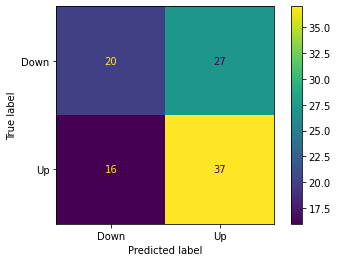

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(val_y, preds>0.4, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=["Down", "Up"])
disp.plot()
plt.show()